<a href="https://colab.research.google.com/github/madhavgn007/Photos2Sketch_Sketch2Photo/blob/main/src/S2P/UNet_S2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import numpy as np
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input


In [ ]:
def sorted_alphanumeric(data):
    """Sort list of strings alphanumerically"""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=alphanum_key)

def preprocess_image(img_path, size):
    """Load, resize, normalize, and augment image"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (size, size))
    img_normalized = img_resized / 255.0
    return img_normalized

def augment_image(img):
    """Flip and rotate image"""
    flipped_img = cv2.flip(img, 1)
    img_vert_flip = cv2.rotate(img, cv2.ROTATE_180)
    flipped_img_vert_flip = cv2.rotate(flipped_img, cv2.ROTATE_180)
    img_right = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    flipped_img_right = cv2.rotate(flipped_img, cv2.ROTATE_90_CLOCKWISE)
    img_left = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    flipped_img_left = cv2.rotate(flipped_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return [img, flipped_img, img_vert_flip, flipped_img_vert_flip, img_right, flipped_img_right, img_left, flipped_img_left]

# Define the directory where the images are located
photos = "../../data/raw/CUHK_training_cropped_photos/"
sketches = "../../data/raw/CUHK_training_cropped_sketches/"

# Define the image size
SIZE = 256

# Load and preprocess photos and sketches
photo_files = sorted_alphanumeric(os.listdir(photos))
sketch_files = sorted_alphanumeric(os.listdir(sketches))

X_train = []
y_train = []
for pf, sf in zip(photo_files, sketch_files):
    # Load and augment photo
    photo_path = os.path.join(photos, pf)
    photo_aug = augment_image(preprocess_image(photo_path, SIZE))
    # Load and augment sketch
    sketch_path = os.path.join(sketches, sf)
    sketch_aug = augment_image(preprocess_image(sketch_path, SIZE))
    # Combine photo and sketch augmentations
    for i, j in zip(photo_aug, sketch_aug):
        X_train.append(i)
        y_train.append(j)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split into train and test sets
n_train = 1400
X_test = X_train[n_train:]
y_test = y_train[n_train:]
X_train = X_train[:n_train]
y_train = y_train[:n_train]

In [ ]:
import tensorflow as tf

# Function to create downsampling block
def downsample(filters, size, apply_batchnorm=True):

    # Define Sequential model for downsampling
    result = tf.keras.Sequential()
    # Add Conv2D layer
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer="he_normal", use_bias=False))

    # Add BatchNormalization layer
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    # Add LeakyReLU activation layer
    result.add(tf.keras.layers.LeakyReLU())

    return result

# Function to create upsampling block
def upsample(filters, size, apply_dropout=False):

    # Define Sequential model for upsampling
    result = tf.keras.Sequential()
    # Add Conv2DTranspose layer
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer="he_normal", use_bias=False))

    # Add BatchNormalization layer
    result.add(tf.keras.layers.BatchNormalization())

    # Add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.1))

    # Add ReLU activation layer
    result.add(tf.keras.layers.ReLU())

    return result

# Function to create U-Net model
def unet_model(output_channels):
    # Define input shape
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Define downsampling path
    down_stack = [
        downsample(16, 3, apply_batchnorm=False),
        downsample(32, 3),
        downsample(64, 3),
        downsample(128, 3),
        downsample(256, 3),
        downsample(512, 3),
    ]

    # Define upsampling path
    up_stack = [
        upsample(512, 3, apply_dropout=True),
        upsample(256, 3, apply_dropout=True),
        upsample(128, 3, apply_dropout=True),
        upsample(64, 3),
        upsample(32, 3),
        upsample(16, 3),
    ]

    # Define output layer
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,
                                        padding='same')

    # Define U-Net model
    x = inputs
    # Define skip connections for each layer in down_stack and up_stack
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(output_channels=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 32)   4736        ['sequential[0][0]']             
                                                                                              

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

history = model.fit(y_train, X_train, epochs=100)

In [ ]:
# Plot loss curves
train_loss = history.history['loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(y_test, X_test)

4/4 [==============================] - 0s 16ms/step - loss: 0.0715 - acc: 0.9282


[0.07154753059148788, 0.9282335042953491]

1/1 [==============================] - 0s 25ms/step


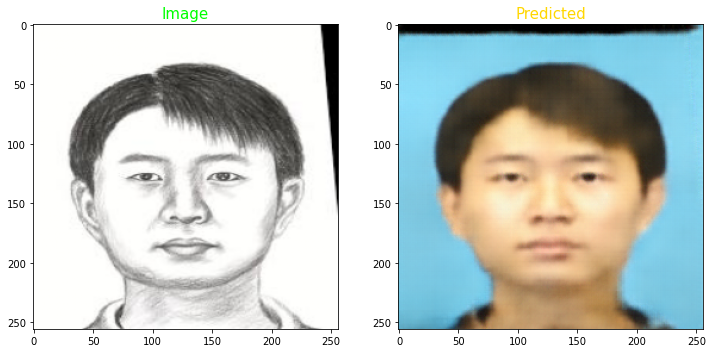

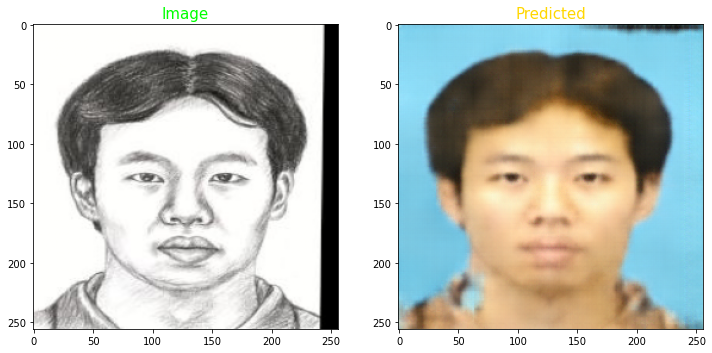

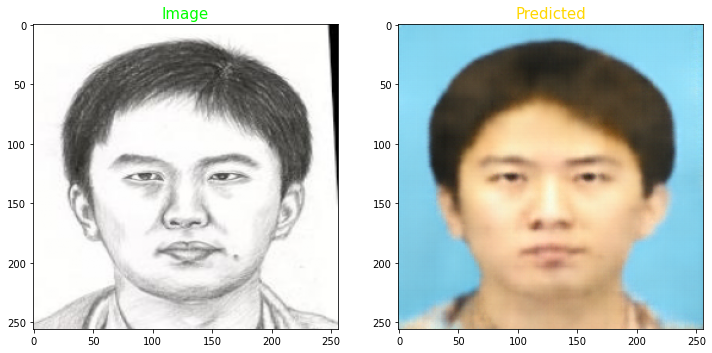

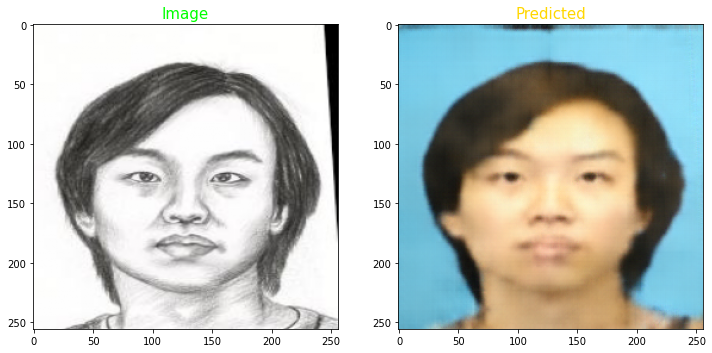

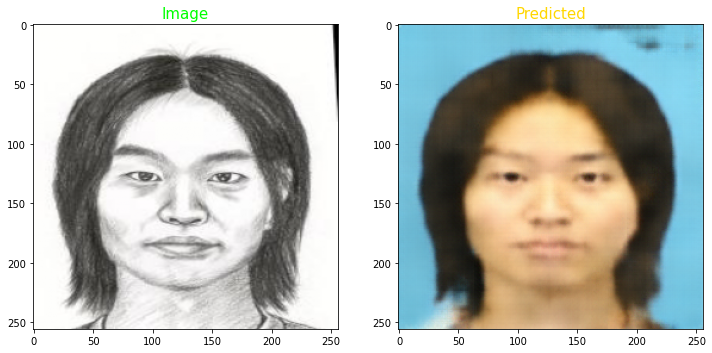

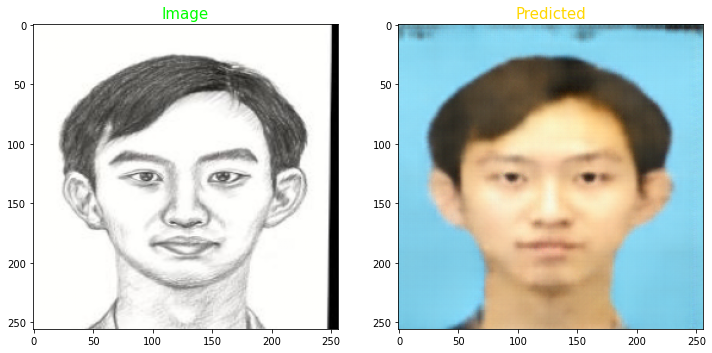

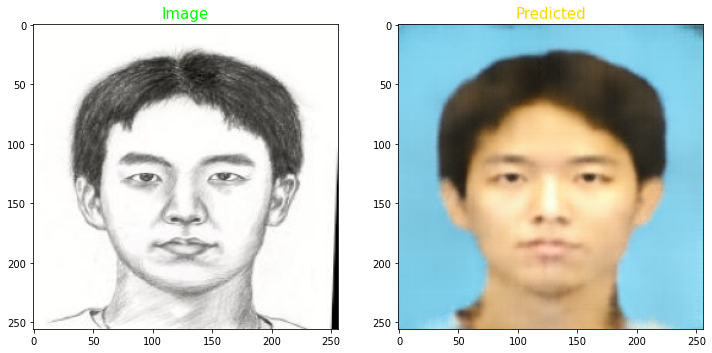

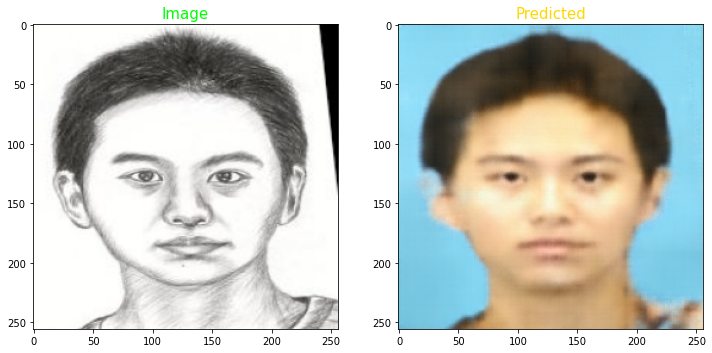

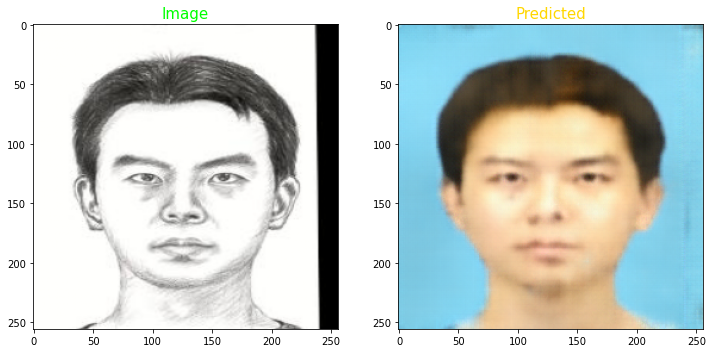

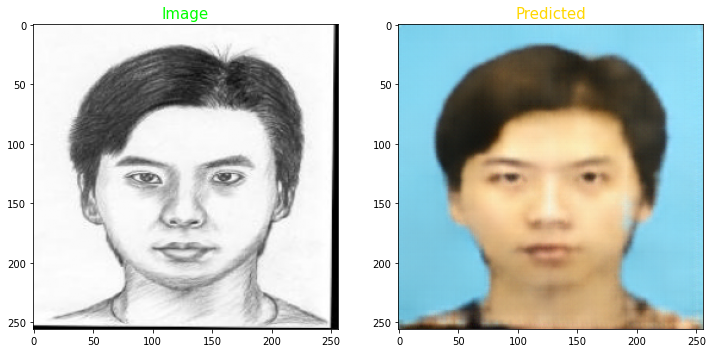

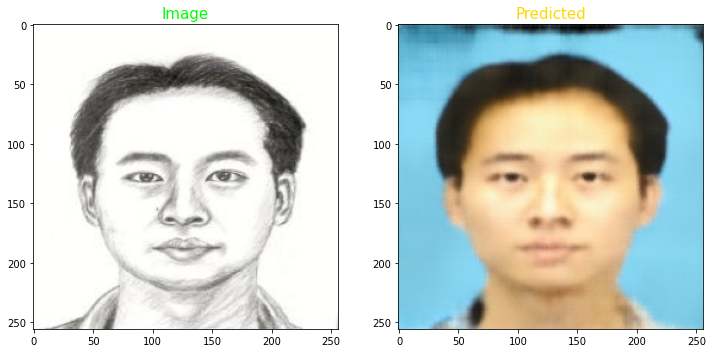

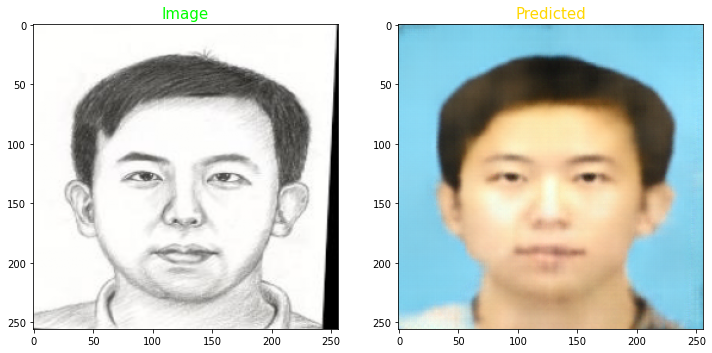

In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)


for i in np.arange(0, 95, 8):
    predicted =np.clip(model.predict(y_test[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(y_test[i],X_test[i],predicted)

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error
import numpy as np

# Generate facial sketches using the autoencoder on test set
predicted = model.predict(y_test)

# Calculate mean squared error between predicted and ground truth sketches
mse = mean_squared_error(X_test.flatten(), predicted.flatten())

# Calculate SSIM score for each generated sketch compared to the ground truth
ssim_scores = [compare_ssim(X_test[i], predicted[i], multichannel=True) for i in range(len(predicted))]

# Calculate the average SSIM score
avg_ssim_score = np.mean(ssim_scores)

print("Average SSIM score:", avg_ssim_score)
print("RMSE score:", np.sqrt(mse))

4/4 [==============================] - 0s 10ms/step


<ipython-input-9-e546e6453b8c>:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_scores = [compare_ssim(X_test[i], predicted[i], multichannel=True) for i in range(len(predicted))]
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Average SSIM score: 0.8353758691576549
RMSE score: 0.11575713507351044
